# Базовые модели

## Обучение базовых моделей (Linear Regression, Decision Tree). Оценка по кросс-валидации.

В этой части проекта мы будем:  

- Базово предобработаем признаки;
- Обучим 2 модели регрессии;
- Посмотрим важности признаков для моделей;
- Поработаем с признаками; 
- Повторно обучим модели;
- Сделаем выводы по работе.

Но первым делом - импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error

import warnings
warnings.filterwarnings('ignore')

Загрузим наш трейн и тест

In [2]:
train = pd.read_csv('../data/raw/train.csv')
X_val = pd.read_csv('../data/raw/test.csv')

print(f'Train shape: {train.shape}')
print(f'Val shape: {X_val.shape}')

Train shape: (360336, 17)
Val shape: (240224, 16)


В тесте отсутствует целевая переменная, оно и понятно, это соревнование с кагл и "мерить" финально модель мы будем там.

Как мы знаем из EDA, выбросы есть, но на текущий момент мы их оставим. Глянем еще раз пропуски:

In [3]:
print(f'Пропущенные значения в train: {train.isnull().sum()}')
print()
print(f'Пропущенные значения в test: {X_val.isnull().sum()}')

Пропущенные значения в train: id                            0
store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0
video_store                   0
salad_bar                     0
prepared_food                 0
florist                       0
cost                          0
dtype: int64

Пропущенные значения в test: id                            0
store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0

Пропусков не обнаружено

Глянем распределение cost (целевой переменной)

Text(0.5, 1.0, 'Распределение cost')

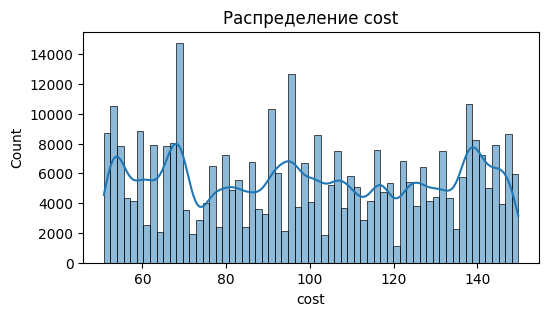

In [4]:
plt.figure(figsize=(20, 3))
plt.subplot(1, 3, 1)
sns.histplot(train['cost'], kde=True)
plt.title('Распределение cost')

Распределение не получится как-то классифицировать

Посмотрим корреляции с целевой переменной здесь, потом перенесем и в EDA

In [5]:
correlation_matrix = train.corr()
cost_correlations = correlation_matrix['cost'].sort_values(ascending=False)
print("Корреляции с cost:")
print(cost_correlations)

Корреляции с cost:
cost                          1.000000
avg_cars_at home(approx).1    0.027098
units_per_case                0.000180
gross_weight                 -0.000116
id                           -0.000611
recyclable_package           -0.001455
num_children_at_home         -0.001727
low_fat                      -0.001975
total_children               -0.007482
store_sales(in millions)     -0.012387
unit_sales(in millions)      -0.026509
store_sqft                   -0.049201
coffee_bar                   -0.052086
salad_bar                    -0.098810
prepared_food                -0.098843
video_store                  -0.106786
florist                      -0.110414
Name: cost, dtype: float64


Высоких корреляций с целевой переменной нет

Для того чтобы нам самим смотреть качество модели разделим train на train и test. Датасет val оставим как есть

In [6]:
train_split, test_split = train_test_split(train, test_size=0.2, random_state=42, shuffle=True)

Смотрим наши наборы:

In [7]:
print('Размеры данных:')
print(f'Train: {train_split.shape}')
print(f'Test: {test_split.shape}')
print(f'Validation: {X_val.shape}')

Размеры данных:
Train: (288268, 17)
Test: (72068, 17)
Validation: (240224, 16)


Подготовка данных для модели

In [8]:
X_train = train_split.drop(['id', 'cost'], axis=1)
y_train = train_split['cost']

X_test = test_split.drop(['id', 'cost'], axis=1)
y_test = test_split['cost']

Масштабирование признаков

In [9]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Linear Regression

In [10]:
model = LinearRegression()

In [11]:
model.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [12]:
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

Оценка модели

In [13]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

RMSLE с гарантией неотрицательных предсказаний

In [14]:
y_train_pred_non_neg = np.maximum(y_train_pred, 0)
y_test_pred_non_neg = np.maximum(y_test_pred, 0)

train_rmsle = np.sqrt(mean_squared_log_error(y_train, y_train_pred_non_neg))
test_rmsle = np.sqrt(mean_squared_log_error(y_test, y_test_pred_non_neg))

In [15]:
print("\n=== РЕЗУЛЬТАТЫ МОДЕЛИ ===")
print(f"TRAIN SET:")
print(f"RMSE: {train_rmse:.2f}")
print(f"RMSLE: {train_rmsle:.4f}")

print(f"\nTEST SET:")
print(f"RMSE: {test_rmse:.2f}")
print(f"RMSLE: {test_rmsle:.4f}")


=== РЕЗУЛЬТАТЫ МОДЕЛИ ===
TRAIN SET:
RMSE: 29.64
RMSLE: 0.3169

TEST SET:
RMSE: 29.66
RMSLE: 0.3174


Анализ важности признаков

In [16]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': model.coef_,
    'abs_importance': np.abs(model.coef_)
}).sort_values('abs_importance', ascending=False)

print("\n=== ВАЖНОСТЬ ПРИЗНАКОВ ===")
print(feature_importance.head(10))


=== ВАЖНОСТЬ ПРИЗНАКОВ ===
                       feature  coefficient  abs_importance
12                   salad_bar     7.140101        7.140101
13               prepared_food    -6.863604        6.863604
14                     florist    -2.463832        2.463832
11                 video_store    -2.266859        2.266859
9                   store_sqft    -1.761124        1.761124
4   avg_cars_at home(approx).1     0.821250        0.821250
10                  coffee_bar     0.539393        0.539393
1      unit_sales(in millions)    -0.321312        0.321312
2               total_children    -0.310976        0.310976
3         num_children_at_home    -0.089937        0.089937


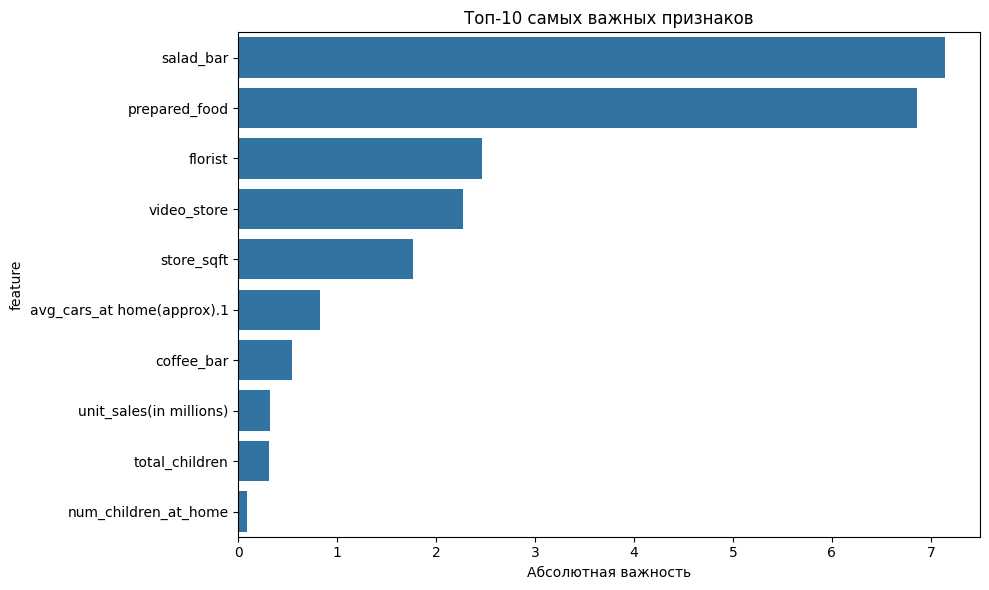

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='abs_importance', y='feature')
plt.title('Топ-10 самых важных признаков')
plt.xlabel('Абсолютная важность')
plt.tight_layout()
plt.show()

**Короткий вывод по линейной модели**

Производительность модели:  
- RMSE ≈ 29.6 - высокий показатель, указывает на большие абсолютные ошибки
- RMSLE ≈ 0.317 - хороший показатель, означает что модель лучше предсказывает относительные изменения
- Модель не переобучена (метрики на train и test почти одинаковы)

Самые важные признаки - сервисы магазина:  
- salad_bar (+7.14) - положительно влияет на стоимость кампаний
- prepared_food (-6.86) - отрицательно влияет на стоимость
- florist и video_store - также значимые факторы

Бизнес-метрики не важны:  
- store_sales и unit_sales отсутствуют в топ-10
- Демографические признаки (total_children, num_children_at_home) почти не влияют

### Decision Tree

Делаем все тоже самое и в конце посмотрим на результаты обычного дерева

In [18]:
tree_model = DecisionTreeRegressor(random_state=42, max_depth=10)
tree_model.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


Оценка модели

In [19]:
y_train_pred_tree = tree_model.predict(X_train)
y_test_pred_tree = tree_model.predict(X_test)

train_rmse_tree = np.sqrt(mean_squared_error(y_train, y_train_pred_tree))
test_rmse_tree = np.sqrt(mean_squared_error(y_test, y_test_pred_tree))

In [20]:
y_train_pred_tree_non_neg = np.maximum(y_train_pred_tree, 0)
y_test_pred_tree_non_neg = np.maximum(y_test_pred_tree, 0)

train_rmsle_tree = np.sqrt(mean_squared_log_error(y_train, y_train_pred_tree_non_neg))
test_rmsle_tree = np.sqrt(mean_squared_log_error(y_test, y_test_pred_tree_non_neg))

In [21]:
print("\n=== РЕЗУЛЬТАТЫ ДЕРЕВА РЕШЕНИЙ ===")
print(f"TRAIN SET:")
print(f"RMSE: {train_rmse_tree:.2f}")
print(f"RMSLE: {train_rmsle_tree:.4f}")

print(f"\nTEST SET:")
print(f"RMSE: {test_rmse_tree:.2f}")
print(f"RMSLE: {test_rmsle_tree:.4f}")


=== РЕЗУЛЬТАТЫ ДЕРЕВА РЕШЕНИЙ ===
TRAIN SET:
RMSE: 28.20
RMSLE: 0.3011

TEST SET:
RMSE: 28.48
RMSLE: 0.3042


Важность признаков для дерева

In [22]:
tree_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': tree_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== ВАЖНОСТЬ ПРИЗНАКОВ (ДЕРЕВО) ===")
print(tree_feature_importance.head(10))


=== ВАЖНОСТЬ ПРИЗНАКОВ (ДЕРЕВО) ===
                       feature  importance
9                   store_sqft    0.389982
2               total_children    0.157346
4   avg_cars_at home(approx).1    0.125866
14                     florist    0.107177
3         num_children_at_home    0.094496
10                  coffee_bar    0.024426
13               prepared_food    0.024032
5                 gross_weight    0.019336
0     store_sales(in millions)    0.018793
11                 video_store    0.015887


**Короткий вывод по дереву решений**

Производительность модели:  
- RMSE ≈ 28.4 - немного лучше линейной регрессии (29.6)
- RMSLE ≈ 0.303 - улучшение по сравнению с линейной регрессией (0.317)
- Модель не переобучена (метрики на train и test почти одинаковы)

Самые важные признаки - сервисы магазина:  
- store_sqft (39%) - самый важный признак для дерева
- Демографические признаки вышли на первые места:
    * total_children (16%)
    * avg_cars_at_home (13%)
    * num_children_at_home (9%)
- Сервисы магазина стали менее важными

Бизнес-метрики появились в топе:  
- store_sales вошел в топ-10 важности
- В отличие от линейной регрессии, где бизнес-показатели были незначимы

**Итоговый вывод по блоку и план дальнейшей работы**

Текущие результаты:
- Линейная регрессия: RMSE=29.66, RMSLE=0.3174
- Дерево решений: RMSE=28.48, RMSLE=0.3042
- Дерево показывает лучшие результаты на 4% по RMSE и 4% по RMSLE


План улучшения:
1. Глубокая предобработка признаков
- Анализ и обработка выбросов в ключевых признаках (store_sqft, store_sales)
- Преобразование skewed-признаков (логарифмирование, корень)
- Создание интервальных признаков из непрерывных переменных

2. Расширенный feature engineering

3. Тестирование ансамблевых методов
- Random Forest - для уменьшения дисперсии
- Gradient Boosting (XGBoost, LightGBM) - часто лучшие для табличных данных
- Stacking - комбинация сильных сторон разных моделей

4. Анализ целевой переменной
- Исследование распределения Cost - возможно, логарифмирование целевой переменной
- Проверка на кластеризацию - возможно, несколько типов магазинов с разной структурой затрат